![IDAL](https://i.imgur.com/tIKXIG1.jpg)  

#<strong>**Máster en Inteligencia Artificial Avanzada y Aplicada  IA^3**</strong>

## **Construcción de un modelo de clasificación de imagenes**

Este ejercico desarrolla el caso de construir un modelo de clasificación de imagenes para tres tipos de categorias:

- clase 0: cat (gato)
- clase 1: dog (perro)
- clase 2: wild (animal salvaje)

Utilizando como técnica para prevenir el overfiting el data augmentation

In [1]:
# Basado en parte de:
# https://github.com/fchollet/deep-learning-with-python-notebooks

In [2]:
COLAB = True

## **Listado de Bibliotecas**

In [3]:
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from keras.models import Sequential, load_model, Model
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense, GlobalAveragePooling2D
from keras import backend as K
from keras.callbacks import ModelCheckpoint
from keras import regularizers
from keras import optimizers
from keras import models
from glob import glob
import cv2

import matplotlib.pyplot as plt
import numpy as np

from IPython.display import SVG, display, clear_output
from keras.utils.vis_utils import model_to_dot

from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

%matplotlib inline

Si se desea ejecutar en local:

- Descargar el dataset de: https://drive.google.com/file/d/1kCpxp2qY5YhNZW4d43yPw8TloqQVTzaq/view?usp=sharing


- Poner variable COLAB a False

## **Descarga de Dataset y listado de estructura de datos**

In [4]:
!ls

sample_data


In [5]:
if COLAB:
    from google_drive_downloader import GoogleDriveDownloader as gdd
    gdd.download_file_from_google_drive(file_id='1kCpxp2qY5YhNZW4d43yPw8TloqQVTzaq',
                                        dest_path='./animals.zip', unzip=True)

Unzipping...Done.


In [6]:
!ls

animals  animals.zip  sample_data


In [7]:
!ls animals

test  train  val


In [8]:
!ls animals/train

cat  dog  wild


## **Muestra de Imagenes del dataset**

In [9]:
ficheros = glob("./animals/train/cat/*jpg")
ficheros[0]

'./animals/train/cat/pixabay_cat_001426.jpg'

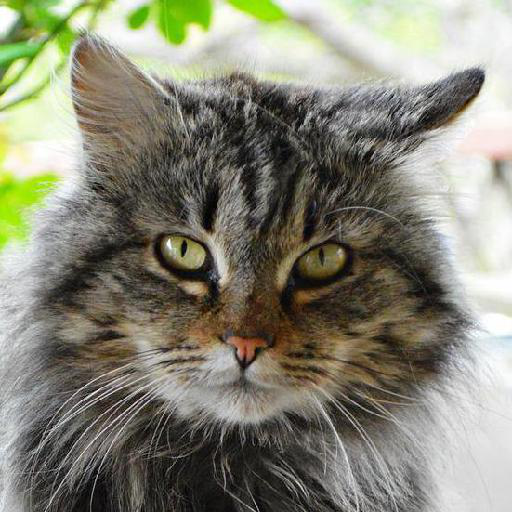

In [10]:
for fich in ficheros[:1]:
    imagen = load_img(fich)
    display(imagen)
    print()

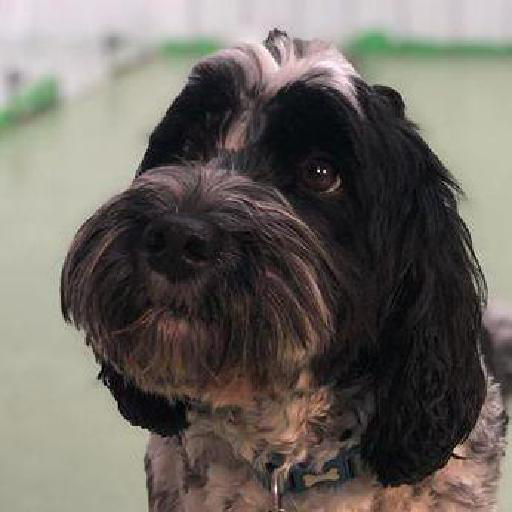

In [11]:
ficheros = glob("./animals/train/dog/*jpg")
for fich in ficheros[:1]:
    imagen = load_img(fich)
    display(imagen)
    print()

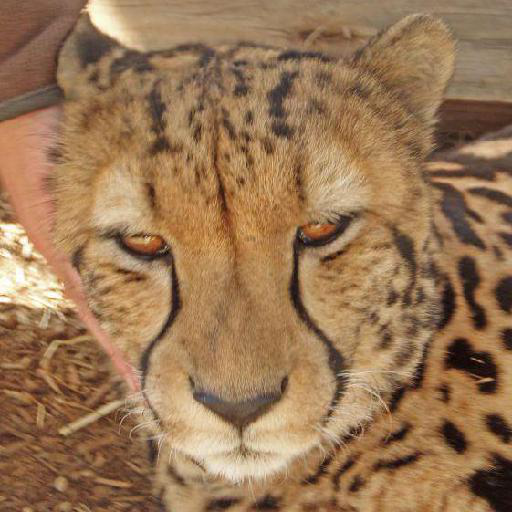

In [12]:
ficheros = glob("./animals/train/wild/*jpg")
for fich in ficheros[:1]:
    imagen = load_img(fich)
    display(imagen)
    print()

## **Red convolucional**

In [13]:
# Definimos los directorios para el dataset animals
train_dir      = 'animals/train'
validation_dir = 'animals/val'
test_dir       = 'animals/test'

# Definimos el tamaño del batch
batch_size     = 16

In [14]:
# dimensiones a las que vamos a llevar las imágenes
img_width, img_height = 150, 150
normed_dims = (img_height, img_width)

In [15]:
normed_dims

(150, 150)

In [16]:
# Desarrollando la arquitectura del modelo

model = Sequential()
model.add(Conv2D(32, (3,3), activation='relu',input_shape=normed_dims+(3,)))
model.add(MaxPooling2D((2,2)))

model.add(Conv2D(32, (3,3), activation='relu'))
model.add(MaxPooling2D((2,2)))

model.add(Conv2D(64, (3,3), activation='relu'))
model.add(MaxPooling2D((2,2)))

model.add(Flatten())
# aqui empieza la red neuronal 'standard'
model.add(Dropout(0.5))

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(3))
model.add(Activation("softmax")) # Separamos la función de activación del dense para el

In [17]:
# cálculo posterior de los heatmaps
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=optimizers.Adam(lr=1e-4),
              metrics=['accuracy'])

In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 18496)             0

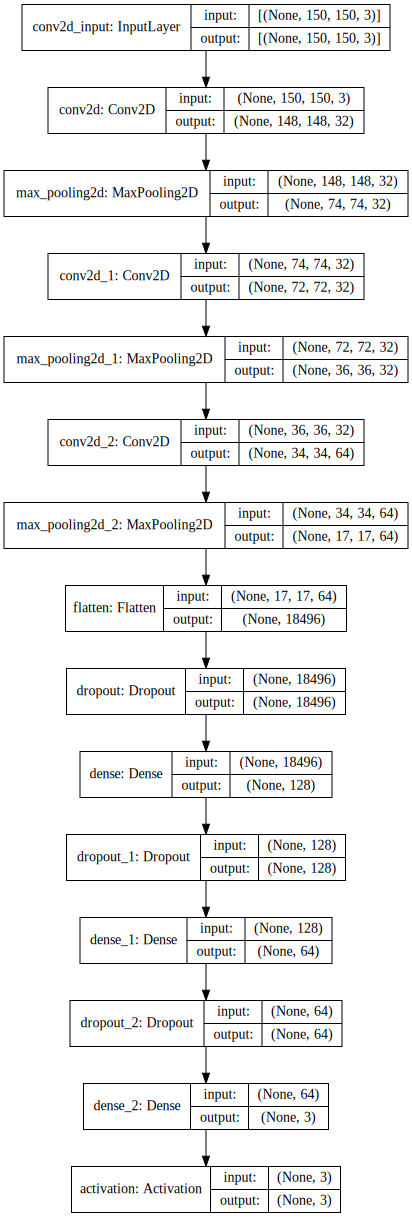

In [19]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

# Dibujando el diagrama del modelo
if COLAB:
    display(SVG(model_to_dot(model, show_shapes=True,dpi=72).create(prog='dot', format='svg')))
else:
    display(SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg')))

In [20]:
#Definiendo una función para preprocess_input
preprocess_input = lambda x:x/255.

In [21]:
#Definiendo los data generadores para train, val y test
train_datagen = ImageDataGenerator(
    dtype='float32',
    preprocessing_function = preprocess_input,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    fill_mode='nearest',
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

val_datagen  = ImageDataGenerator(dtype='float32',
                                  preprocessing_function = preprocess_input)

test_datagen = ImageDataGenerator(dtype='float32',
                                  preprocessing_function = preprocess_input)

In [22]:
validation_dir, normed_dims

('animals/val', (150, 150))

In [23]:
# Definiendo los generator para train, val y test
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=normed_dims,
    batch_size=batch_size,
    shuffle=True,
    class_mode='sparse') # binary: 0/1. Sparse: entero a partir de 0

validation_generator = val_datagen.flow_from_directory(
    validation_dir,
    target_size=normed_dims,
    batch_size=batch_size,
    shuffle=False,
    class_mode='sparse') # binary: 0/1. Sparse: entero a partir de 0

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=normed_dims,
    batch_size=batch_size,
    shuffle=False,
    class_mode='sparse') # binary: 0/1. Sparse: entero a partir de 0

Found 10920 images belonging to 3 classes.
Found 3120 images belonging to 3 classes.
Found 1560 images belonging to 3 classes.


In [24]:
train_generator.class_indices

{'cat': 0, 'dog': 1, 'wild': 2}

In [25]:
from matplotlib.ticker import MaxNLocator

def grafica_entrenamiento(tr_acc, val_acc, tr_loss, val_loss, best_i,
                          figsize=(10,4)):
    plt.figure(figsize=figsize)
    ax = plt.subplot(1,2,1)
    plt.plot(1+np.arange(len(tr_acc)),  100*np.array(tr_acc))
    plt.plot(1+np.arange(len(val_acc)), 100*np.array(val_acc))
    plt.plot(1+best_i, 100*val_acc[best_i], 'or')
    plt.title('tasa de acierto del modelo (%)', fontsize=18)
    plt.ylabel('tasa de acierto (%)', fontsize=18)
    plt.xlabel('época', fontsize=18)
    plt.legend(['entrenamiento', 'validación'], loc='upper left')
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))

    plt.subplot(1,2,2)
    plt.plot(1+np.arange(len(tr_acc)), np.array(tr_loss))
    plt.plot(1+np.arange(len(val_acc)), np.array(val_loss))
    plt.plot(1+best_i, val_loss[best_i], 'or')
    plt.title('loss del modelo', fontsize=18)
    plt.ylabel('loss', fontsize=18)
    plt.xlabel('época', fontsize=18)
    plt.legend(['entrenamiento', 'validación'], loc='upper left')
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.show()

In [26]:
#Iniciando algunas variables
acum_tr_acc   = []
acum_val_acc  = []
best_val_acc  = -1000
acum_tr_loss  = []
acum_val_loss = []

In [27]:
number_train_samples = train_generator.n
number_val_samples   = validation_generator.n
number_test_samples  = test_generator.n

number_train_samples, number_val_samples, number_test_samples

(10920, 3120, 1560)

In [28]:
epochs = 50

modelpath="animals_model_current_best_1.h5"

checkpoint = ModelCheckpoint(modelpath, monitor='val_accuracy', verbose=1,
                             save_best_only=True,
                             mode='max') # graba sólo los que mejoran en validación

callbacks_list = [checkpoint]

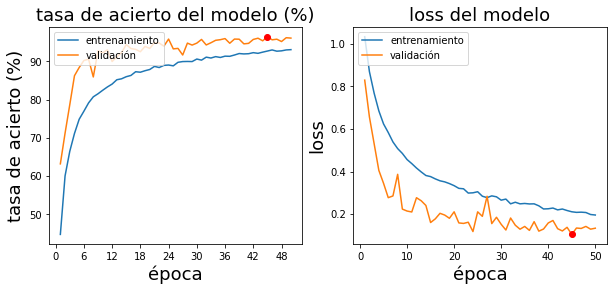

In [29]:
for e in range(epochs):    
    history = model.fit(train_generator, 
                        steps_per_epoch=number_train_samples // batch_size,
                        epochs=1,
                        callbacks=callbacks_list,
                        verbose=1,
                        shuffle = False,
                        validation_data=validation_generator,
                        validation_steps=number_val_samples // batch_size
                       )
    
    if history.history['val_accuracy'][-1] > best_val_acc:
        print("La precisión de la validación mejoró de",
               best_val_acc, 'a', history.history['val_accuracy'])        
        print("grabando los pesos")
        best_val_acc = history.history['val_accuracy'][-1]        
    
    acum_tr_acc.append(history.history['accuracy'][0])
    acum_tr_loss.append(history.history['loss'][0])

    acum_val_acc.append(history.history['val_accuracy'][0])    
    acum_val_loss.append(history.history['val_loss'][0])
    
    if len(acum_tr_acc) > 1:
        clear_output()
        best_i = np.argmax(acum_val_acc)
        grafica_entrenamiento(acum_tr_acc, acum_val_acc, acum_tr_loss, acum_val_loss, best_i)

In [30]:
!ls -la

total 716876
drwxr-xr-x 1 root root      4096 Mar  5 05:55 .
drwxr-xr-x 1 root root      4096 Mar  5 05:52 ..
drwxr-xr-x 5 root root      4096 Mar  5 05:53 animals
-rw-r--r-- 1 root root  28922464 Mar  5 07:13 animals_model_current_best_1.h5
-rw-r--r-- 1 root root 705126532 Mar  5 05:53 animals.zip
drwxr-xr-x 4 root root      4096 Mar  1 14:35 .config
drwxr-xr-x 1 root root      4096 Mar  1 14:35 sample_data


## **Resultados obtenidos**

### Resultados según keras cargando los datasets en lotes:

In [31]:
scores_tr = model.evaluate(train_generator)
print('Train loss    :', scores_tr[0])
print('Train accuracy:', scores_tr[1])
print()

scores_val = model.evaluate(validation_generator)
print('Val loss    :', scores_val[0])
print('Val accuracy:', scores_val[1])
print()

scores_te = model.evaluate(test_generator)
print('Test loss     :', scores_te[0])
print('Test accuracy :', scores_te[1])

683/683 [==============================] - 89s 131ms/step - loss: 0.1402 - accuracy: 0.9487
Train loss    : 0.14017504453659058
Train accuracy: 0.9487179517745972

195/195 [==============================] - 13s 66ms/step - loss: 0.1339 - accuracy: 0.9606
Val loss    : 0.13388851284980774
Val accuracy: 0.9605769515037537

98/98 [==============================] - 7s 66ms/step - loss: 0.1558 - accuracy: 0.9513
Test loss     : 0.15578684210777283
Test accuracy : 0.9512820243835449


In [32]:
test_generator.classes

array([0, 0, 0, ..., 2, 2, 2], dtype=int32)

## **Visualización de ejemplos de test**

In [33]:
test_datagen2 = ImageDataGenerator(dtype='float32',
                                   preprocessing_function = preprocess_input)

test_generator2 = test_datagen2.flow_from_directory(
    test_dir,
    target_size=normed_dims,
    batch_size=test_generator.n, # todas las imágnes del directorio test
    shuffle=False,
    class_mode='sparse')

Found 1560 images belonging to 3 classes.


In [34]:
test_generator2.reset()
X_te, y_te = test_generator2.next()

In [35]:
X_te.shape

(1560, 150, 150, 3)

In [36]:
class_indices = test_generator2.class_indices
class_indices

{'cat': 0, 'dog': 1, 'wild': 2}

In [37]:
 ind_cat  = np.where(y_te==class_indices["cat"])[0]
 ind_dog  = np.where(y_te==class_indices["dog"])[0]
 ind_wild = np.where(y_te==class_indices["wild"])[0]
 
 ind_cat.shape, ind_dog.shape,ind_wild.shape

((520,), (520,), (520,))

In [38]:
def show_image(ind_te1):
  image = X_te[ind_te1].copy()
  plt.imshow(image, cmap='jet')
  plt.axis("off")

  plt.show()
  
  p = model.predict(np.expand_dims(image, axis=0))[0][class_indices["cat"]]
  print("Probabilidad gato : {:2.1f}%".format(100*p))
  
  p = model.predict(np.expand_dims(image, axis=0))[0][class_indices["dog"]]
  print("Probabilidad perro: {:2.1f}%".format(100*p))
  
  p = model.predict(np.expand_dims(image, axis=0))[0][class_indices["wild"]]
  print("Probabilidad salvaje: {:2.1f}%".format(100*p))
  print("\n")

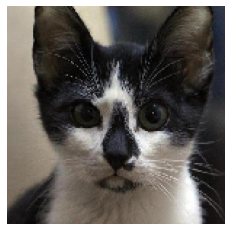

Probabilidad gato : 100.0%
Probabilidad perro: 0.0%
Probabilidad salvaje: 0.0%




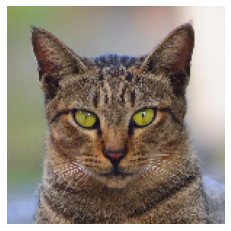

Probabilidad gato : 100.0%
Probabilidad perro: 0.0%
Probabilidad salvaje: 0.0%




In [39]:
# Escogemos algunos valores de las 1560 imagenes para test
ind_te1 = 117

for i in range(ind_te1, ind_te1 + 2):
  show_image (i)

## **Visualización del funcionamiento de la red**

In [40]:
weights = model.get_weights()
print(np.shape(weights))

for i in range(len(weights)):
    print('shape of weights[%d]: ' % i, np.shape(weights[i]))

(12,)
shape of weights[0]:  (3, 3, 3, 32)
shape of weights[1]:  (32,)
shape of weights[2]:  (3, 3, 32, 32)
shape of weights[3]:  (32,)
shape of weights[4]:  (3, 3, 32, 64)
shape of weights[5]:  (64,)
shape of weights[6]:  (18496, 128)
shape of weights[7]:  (128,)
shape of weights[8]:  (128, 64)
shape of weights[9]:  (64,)
shape of weights[10]:  (64, 3)
shape of weights[11]:  (3,)


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


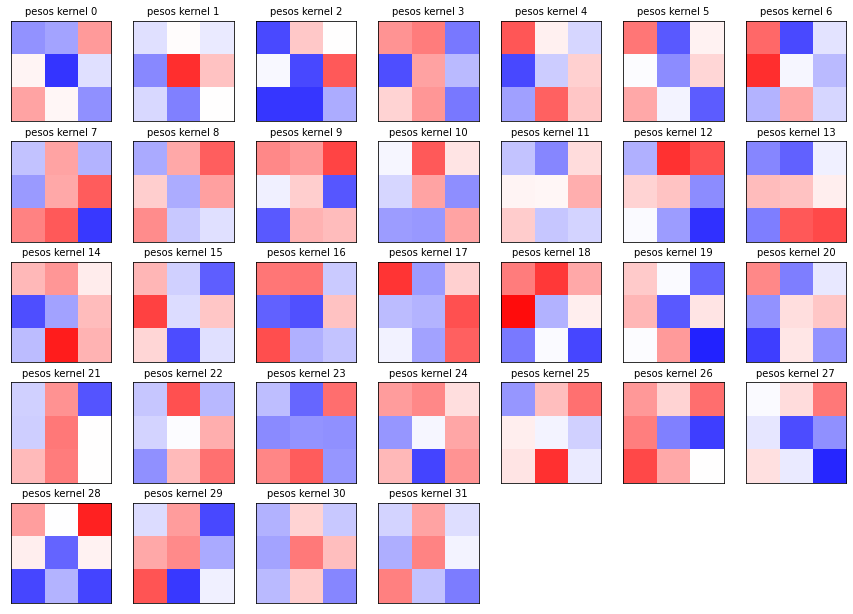

In [41]:
# kernels de la primera capa convolucional
ncapa = 0

nfilters = weights[ncapa].shape[3]
ncols = 7 # número de columnas en la figura

ma = abs(weights[ncapa]).max()
nrows = int(np.ceil(nfilters/ncols)) # número de filas en la figura

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15,15*nrows/ncols))
axes_r = axes.ravel()

for i in range(nfilters):
    kernel = weights[ncapa][:,:,2,i]
    ax = axes_r[i]
    ax.imshow(kernel, vmin=-ma, vmax=ma, cmap='bwr')
    ax.set_xticks([]); ax.set_yticks([])
    ax.set_title('pesos kernel %d' % i, fontsize=10)

for i in range(nfilters,nrows*ncols):
    fig.delaxes(axes_r[i])

### **Visualización de las salidas de una sola capa**

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_input (InputLayer)    [(None, 150, 150, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 148, 148, 32)      896       
Total params: 896
Trainable params: 896
Non-trainable params: 0
_________________________________________________________________





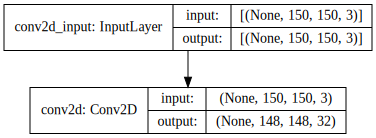

In [42]:
# salida de una sola capa
ncapa = 0
intermediate_layer_model = Model(inputs=model.input,
                                 outputs=model.layers[ncapa].output)
intermediate_layer_model.summary()

print("\n\n")

if COLAB:
    display(SVG(model_to_dot(intermediate_layer_model,show_shapes=True,dpi=72).create(prog='dot', format='svg')))
else:
    display(SVG(model_to_dot(intermediate_layer_model,show_shapes=True).create(prog='dot', format='svg')))

In [43]:
imagen = X_te[1005]
imagen.shape

(150, 150, 3)

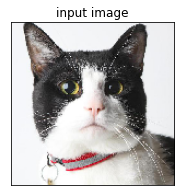

Salidas capa conv2d (1, 148, 148, 32)


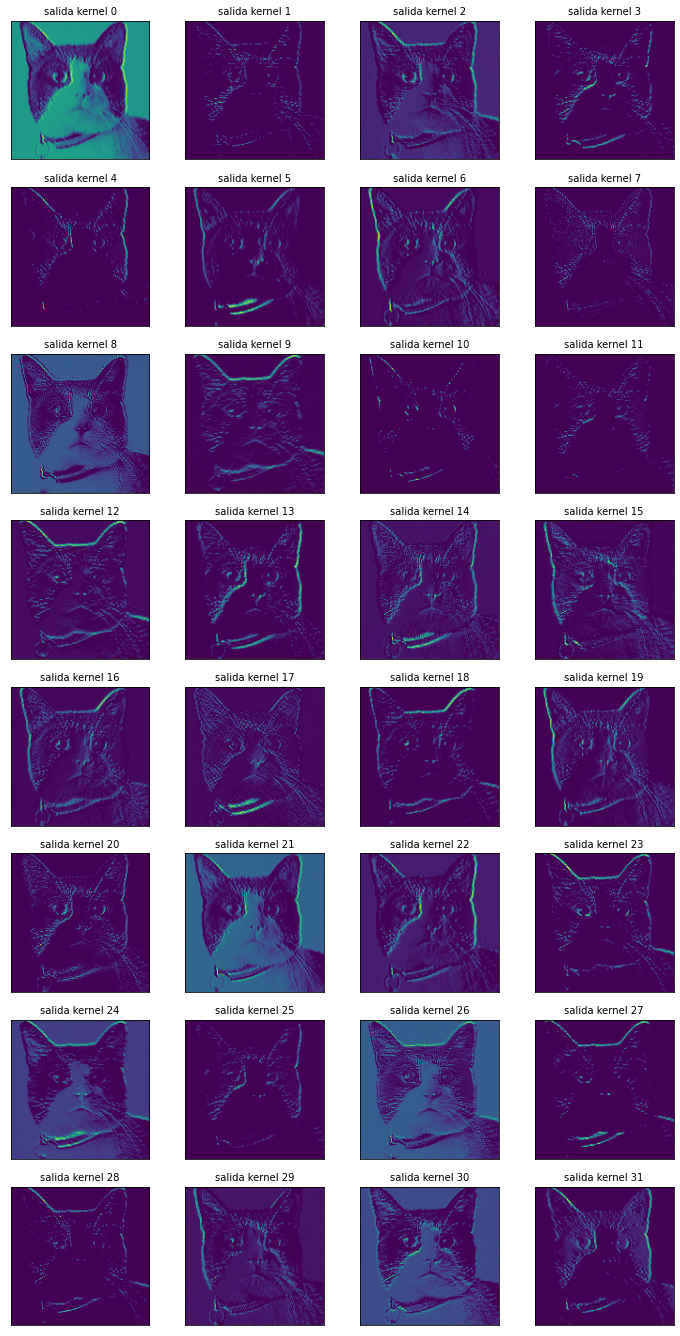

In [44]:
#Se toma la imagen 10 del test
ejemplo = 10

imagen = X_te[ejemplo]
aux = np.expand_dims(imagen, axis=0)
salida_capa = intermediate_layer_model.predict(aux)

plt.figure(figsize=(3,3))
plt.imshow(imagen, cmap='gray')
plt.title('input image', size=12)
plt.xticks(())
plt.yticks(())
plt.show()

print("Salidas capa "+intermediate_layer_model.layers[-1].name, salida_capa.shape)

nsalidas = salida_capa.shape[-1]
ncols = 4
nrows = int(np.ceil(nsalidas / ncols))

ma = abs(salida_capa).max()

plt.subplots(nrows,ncols,figsize = (12, 3*nrows))

for i in range(nsalidas):
    plt.subplot(nrows,ncols,i+1)
    plt.imshow(salida_capa[0,:,:,i], cmap='viridis')
    plt.xticks(())
    plt.yticks(())
    plt.title('salida kernel %d' % i, fontsize=10)

### **Visualización de las salidas de varias capas**

In [45]:
# Now we extract the outputs of the top 6 layers:
layer_outputs = [layer.output for layer in model.layers[:6]]

# Creates a model that will return these outputs, given the model input:
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)

activations = activation_model.predict(X_te[ejemplo:(ejemplo+1)])

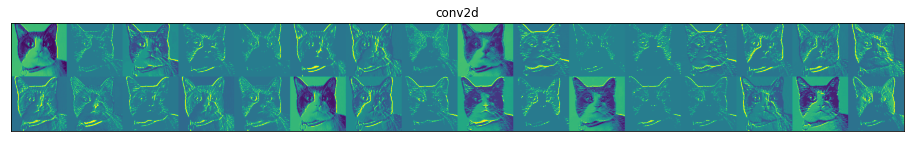

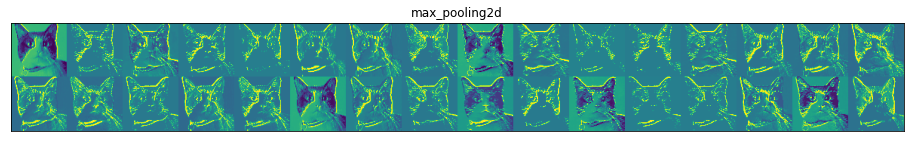

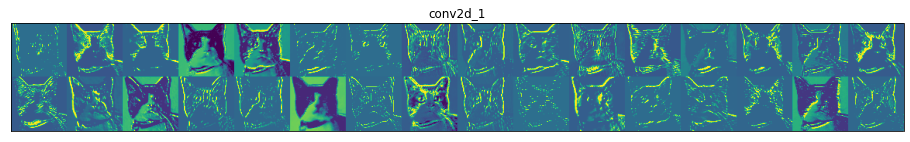

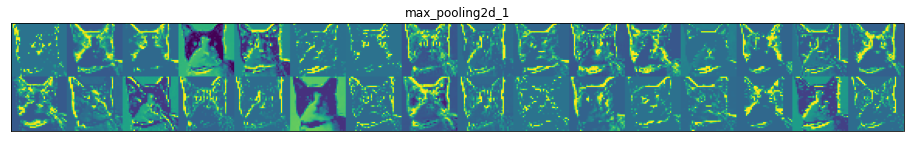

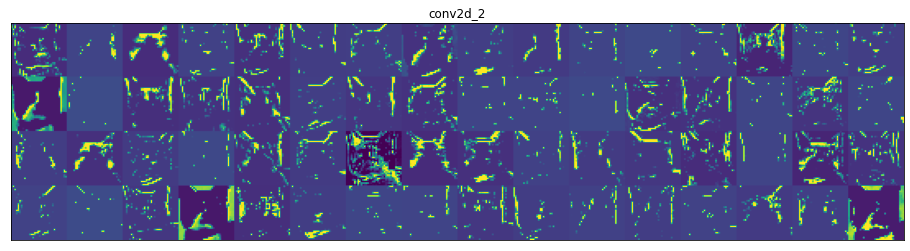

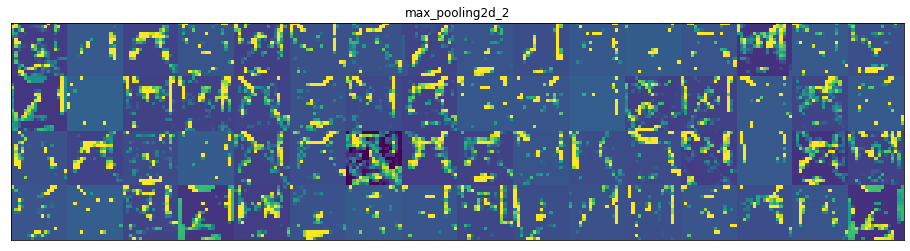

In [46]:
# These are the names of the layers, so can have them as part of our plot
layer_names = []
for layer in model.layers[:8]:
    layer_names.append(layer.name)

images_per_row = 16

# Now let's display our feature maps
for layer_name, layer_activation in zip(layer_names, activations):
    # This is the number of features in the feature map
    n_features = layer_activation.shape[-1]

    # The feature map has shape (1, size, size, n_features)
    size = layer_activation.shape[1]

    # We will tile the activation channels in this matrix
    n_cols = n_features // images_per_row
    display_grid = np.zeros((size * n_cols, images_per_row * size))

    # We'll tile each filter into this big horizontal grid
    for col in range(n_cols):
        for row in range(images_per_row):
            channel_image = layer_activation[0,
                                             :, :,
                                             col * images_per_row + row]
            # Post-process the feature to make it visually palatable
            channel_image -= channel_image.mean()
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size,
                         row * size : (row + 1) * size] = channel_image

    # Display the grid
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(display_grid, aspect='auto', cmap='viridis')

### **¿A qué partes de la imagen de entrada es más sensible la salida de la red?**

### **GradCam:**

(de https://medium.com/analytics-vidhya/visualizing-activation-heatmaps-using-tensorflow-5bdba018f759)

1- Calcular para una imagen la salida del modelo y la salida de la última capa convolucional

2- Encuentrar la neurona de salida más activa (que es la que determina la clase predicha)

3- Calcular el gradiente de dicha neurona de salida con respecto a la última capa convolucional

3- Promediar y pesar esto con la salida de la última capa convolucional

4- Normalizar entre 0 y 1 para visualizar

5- Convertir a RGB y superponerla a la imagen original

**Funciones que calculan la sensibilidad de la salida a la entrada:**

In [47]:
import tensorflow as tf

def find_ind_last_conv2D(model):
    ind_last_conv2D_layer = None
    for i,x in enumerate(model.layers):
        if x.__class__.__name__ == "Conv2D":
            ind_last_conv2D_layer = i
    return ind_last_conv2D_layer


def show_heatmap(model, im):
    imag = np.expand_dims(im, axis=0) # de 1 imagen pasamos a 1 conjunto de 1 imagen
        
    # The is the output feature map of the last convolutional layer
    last_conv_layer = model.layers[find_ind_last_conv2D(model)]
    
    # This is the gradient of the "benign" class with regard to
    # the output feature map of last convolutional layer
    with tf.GradientTape() as tape:
        aux = model.output
        #aux = model.layers[-2].output # salida de la última capa densa antes de softmax

        iterate = tf.keras.models.Model([model.inputs], [aux, last_conv_layer.output])
        model_out, last_conv_layer = iterate(imag)
        class_out = model_out[:, np.argmax(model_out[0])]
        grads = tape.gradient(class_out, last_conv_layer)

        # mean intensity of the gradient over a specific feature map channel:
        pooled_grads = K.mean(grads, axis=(0, 1, 2))
    
    heatmap = tf.reduce_mean(tf.multiply(pooled_grads, last_conv_layer), axis=-1)    
    heatmap = np.maximum(heatmap, 0) # se quitan los negativos (se ponen a 0)
    heatmap /= np.max(heatmap) # se normaliza entre 0 y 1
    heatmap = heatmap[0] # pasamos de 1 conjunto de 1 heatmap a 1 heatmap
    
    # We use cv2 to load the original image
    #img = cv2.imread(img_path)
    img = imag[0]
    
    img = np.zeros((im.shape[0],im.shape[1],3))
    #print(im.shape, imag.shape)
    for i in range(3):
        img[:,:,i] = imag[0,:,:,0]

    # We resize the heatmap to have the same size as the original image
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    
    # We convert the heatmap to RGB
    heatmap = np.uint8(255 * heatmap)
    
    # We apply the heatmap to the original image
    #heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET) / 255
    #heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_BONE) / 255
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_HOT) / 255
    
    # 0.4 here is a heatmap intensity factor
    superimposed_img = heatmap * 0.5 + 0.5*im
    #print(heatmap.min(), heatmap.max(), heatmap.mean(), heatmap.std())
    #print(img.min(), img.max(), img.mean(), img.std())
    #print(superimposed_img.min(),  superimposed_img.max(),
    #      superimposed_img.mean(), superimposed_img.std())
    
    plt.figure(figsize=(15,5))
    plt.subplot(1,3,1)
    plt.imshow(im, vmin=0, vmax=1); plt.xticks([]); plt.yticks([])
    
    plt.subplot(1,3,2)
    plt.imshow(heatmap, vmin=0, vmax=1); plt.xticks([]); plt.yticks([])
    
    plt.subplot(1,3,3)
    plt.imshow(superimposed_img, vmin=0, vmax=1); plt.xticks([]); plt.yticks([])
    
    plt.show()
    #print(np.shape(imag))
    prob = 100*model.predict(imag)[0][class_indices["cat"]]
    print("Probabilidad clase gato : {:2.1f}%".format(prob))
    
    prob = 100*model.predict(imag)[0][class_indices["dog"]]
    print("Probabilidad clase perro: {:2.1f}%".format(prob))
    
    prob = 100*model.predict(imag)[0][class_indices["wild"]]
    print("Probabilidad clase salvaje: {:2.1f}%".format(prob))
    
    print("\n")
        
    return heatmap, superimposed_img

**Visualización de mapas de sensibilidades (heatmaps) en varios ejemplos:**

In [48]:
X_te.shape


(1560, 150, 150, 3)

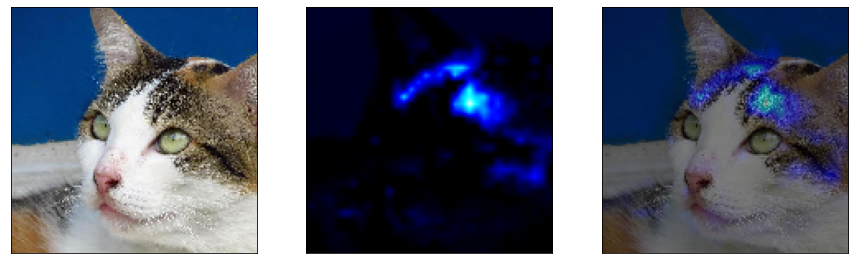

Probabilidad clase gato : 100.0%
Probabilidad clase perro: 0.0%
Probabilidad clase salvaje: 0.0%




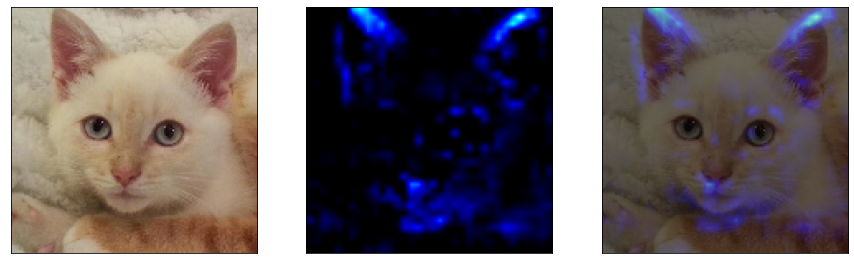

Probabilidad clase gato : 99.1%
Probabilidad clase perro: 0.7%
Probabilidad clase salvaje: 0.1%




In [49]:
ind = 217 # visualizamos 2 ejemplos de test a partir de este (en test hay 1560 ejemplos)

for i in range(ind, ind+2):
    show_heatmap(model, X_te[i])

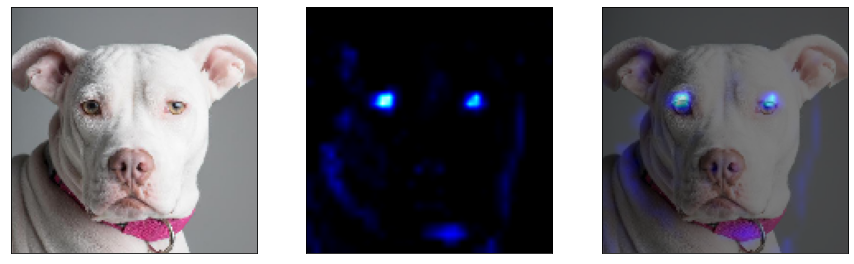

Probabilidad clase gato : 10.1%
Probabilidad clase perro: 89.5%
Probabilidad clase salvaje: 0.4%




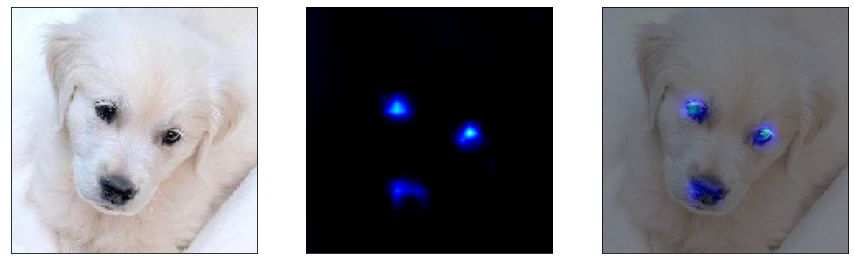

Probabilidad clase gato : 0.2%
Probabilidad clase perro: 96.7%
Probabilidad clase salvaje: 3.1%




In [50]:
ind = 600 # visualizamos 2 ejemplos de test a partir de este (en test hay 1560 ejemplos)

for i in range(ind, ind+2):
    show_heatmap(model, X_te[i])

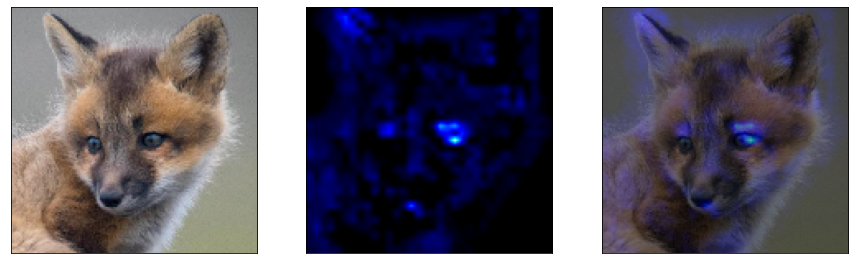

Probabilidad clase gato : 1.7%
Probabilidad clase perro: 12.0%
Probabilidad clase salvaje: 86.3%




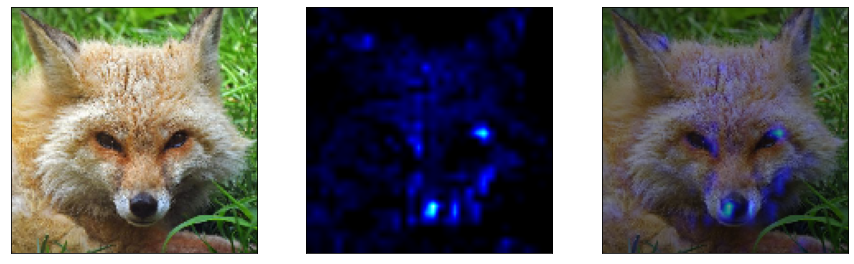

Probabilidad clase gato : 22.3%
Probabilidad clase perro: 11.2%
Probabilidad clase salvaje: 66.5%




In [51]:
ind = 1220  # visualizamos 2 ejemplos de test a partir de este (en test hay 1560 ejemplos)

for i in range(ind, ind+2):
    show_heatmap(model, X_te[i])

### **Ahora analizamos las equivocaciones de la CNN en test cuando intentamos detectar gatos**

- clase 0: cat(gato)
- clase 1: dog(perro) 
- clase 2: wild(animal salvaje)

In [52]:
def listadoError(lc,li):
  le = zip(lc,li)
  return le

In [53]:
def errorPrediccion(clase, listado):
  lc = []
  li = []  
  for i in listado:
      img = X_te[i].copy()
      prd= model.predict(np.expand_dims(img, axis=0))
      c = np.argmax(prd)
      if (c != clase):
        #print(str(c), ' ---->', str(i))
        lc.append(c)
        li.append(i)
        
  la = tuple(listadoError(lc, li))
  la = sorted(la)
  arr = np.array(la)
  for i in arr:
    print('Indice de Foto en el dataset: ', i[1])    
    z= i[1]
    show_heatmap(model, X_te[z])   

**Gatos que la red está segura que son Perros o Animales Salvajes**

Indice de Foto en el dataset:  47


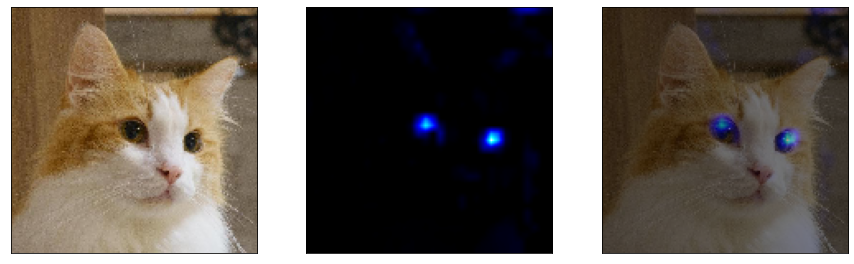

Probabilidad clase gato : 4.4%
Probabilidad clase perro: 87.7%
Probabilidad clase salvaje: 7.9%


Indice de Foto en el dataset:  178


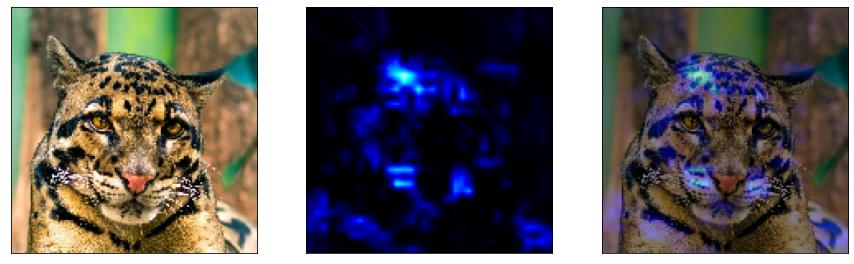

Probabilidad clase gato : 0.1%
Probabilidad clase perro: 0.0%
Probabilidad clase salvaje: 99.9%


Indice de Foto en el dataset:  419


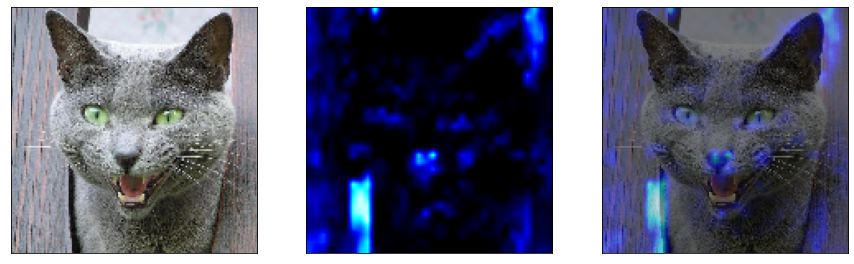

Probabilidad clase gato : 19.8%
Probabilidad clase perro: 5.0%
Probabilidad clase salvaje: 75.2%


Indice de Foto en el dataset:  475


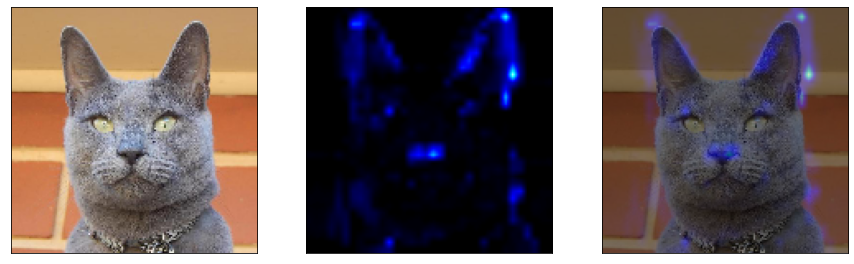

Probabilidad clase gato : 46.3%
Probabilidad clase perro: 2.6%
Probabilidad clase salvaje: 51.1%




In [54]:
errorPrediccion(0, ind_cat)

**Perros que la red está segura que son Gatos o Animales Salvajes**

In [55]:
errorPrediccion(1, ind_dog)

Output hidden; open in https://colab.research.google.com to view.

**Animales Salvajes que la red está segura que son Gatos o Perros**

In [56]:
errorPrediccion(2,ind_wild)

Output hidden; open in https://colab.research.google.com to view.